# Read result file 
    - meta data: available results, mesh, time/freq domain
    - results: displacement and stress

1st step : load dpf client/server, generate documentation if needed

In [1]:
from ansys import dpf
dpf.start_local_server()
#doc = dpf.Operator("html_doc")
#doc.inputs.output_path(r'c:/temp/doc.html')
#doc.run()
import os
res_files = os.getcwd() + r'\..\..\res_files'

server started at --address 10.28.1.60 --port 50052


2nd step : create a model

In [2]:
path = res_files + r'\file_transient.rst'
model = dpf.Model(path)
metadata = model.metadata
results = model.results

In [3]:
print(metadata.result_info)

Static analysis
Unit system: Metric (m, kg, N, s, V, A)
Physics Type: Mecanic
Available results:
     -  displacement                  
     -  force                         
     -  stress                        
     -  volume                        
     -  energy_stiffness_matrix       
     -  hourglass_energy              
     -  thermal_dissipation_energy    
     -  kinetic_energy                
     -  co_energy                     
     -  incremental_energy            
     -  strain                        



In [4]:
print(metadata.meshed_region)

Meshed Region
	1277 nodes
	682 elements
	Unit: m 



In [5]:
print(metadata.time_freq_support)


Time/Frequency Info:
	Number of sets: 206

With complex values
 
 Cumulative      Time (s)       Loadstep     Substep   
     1             0.0             1            1      
     2            1e-05            1            2      
     3            6e-05            1            3      
     4           0.00031           1            4      
     5           0.000935          1            5      
     6            0.0025           1            6      
     7            0.0064           1            7      
     8            0.0114           1            8      
     9            0.0164           1            9      
     10           0.0214           1            10     
     11           0.0264           1            11     
     12           0.0314           1            12     
     13           0.0364           1            13     
     14           0.0414           1            14     
     15           0.0464           1            15     
     16           0.0514           1   

## read displacements and calculate Total deformatiom min max over time

In [6]:
displacements = model.results.displacement()
normOp = dpf.Operator("norm_fc")
minmaxOp = dpf.Operator("min_max_fc")
timeIds = list(range(1,metadata.time_freq_support.n_sets+1))

In [7]:
displacements.inputs.time_scoping.connect(timeIds)
normOp.inputs.connect(displacements.outputs)
minmaxOp.inputs.connect(normOp.outputs)

In [8]:
fieldMin = minmaxOp.outputs.field_min()
fieldMax = minmaxOp.outputs.field_max()

In [9]:
timeSupport = metadata.time_freq_support

In [10]:
timefield = timeSupport.time_frequencies

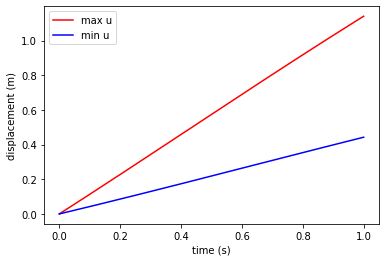

In [11]:
import matplotlib.pyplot as pyplot

pyplot.plot(timefield.data,fieldMax.data,'r',label='max u')
pyplot.plot(timefield.data,fieldMin.data,'b',label="min u")
#pyplot.title("maximum and minimum of displacement over time")
pyplot.xlabel("time (s)")
pyplot.ylabel("displacement (m)")
leg = pyplot.legend()

## read stresses and calculate stress equivalent min max over time

In [12]:
stressOp = results.stress()

In [13]:
stressOp.inputs.time_scoping.connect(timeIds)
stressOp.inputs.requested_location.connect("Nodal")

eqv = stressOp.eqv()
minmaxOp.inputs.fields_container.connect(eqv.outputs)

In [14]:
fieldMin = minmaxOp.outputs.field_min()
fieldMax = minmaxOp.outputs.field_max()

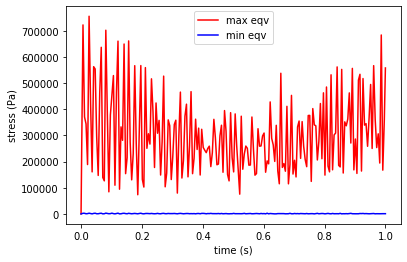

In [15]:
import matplotlib.pyplot as pyplot

pyplot.plot(timefield.data,fieldMax.data,'r',label='max eqv')
pyplot.plot(timefield.data,fieldMin.data,'b',label="min eqv")
#pyplot.title("maximum and minimum of displacement over time")
pyplot.xlabel("time (s)")
pyplot.ylabel("stress (Pa)")
leg = pyplot.legend()

## export to vtk

In [16]:
vtk = dpf.Operator("vtk_export")

In [17]:
vtk.inputs.file_path(r'c:/temp/file_static.vtk')
vtk.inputs.mesh.connect(metadata.meshed_region)
vtk.inputs.fields1.connect(eqv.outputs.fields_container)
vtk.inputs.fields2.connect(displacements.outputs.fields_container)
vtk.run()